# AWS DeepComposer: Train it Again Maestro

## Episode 4 - Music Composition with a Custom Model

---

This notebook is for episode 4 of the <b> AWS DeepComposer: Train it Again Maestro </b> web series on the <b>A Cloud Guru</b> platform.
     
This covers building a custom GAN architecture and training a custom music genre model using Amazon SageMaker. In this exmaple, we will train a reggae model and use it to generate a brand new song.

    
---

In [ ]:
# Create the environment
!conda update --all --y 
!pip install tensorflow-gpu==1.14.0
!pip install numpy==1.16.4
!pip install pretty_midi
!pip install pypianoroll
!pip install music21
!pip install seaborn
!pip install --ignore-installed moviepy

In [2]:
# IMPORTS
import os 
import numpy as np
from numpy import asarray
from numpy import save
from PIL import Image
import logging
import pypianoroll
from pypianoroll import Multitrack, Track
import scipy.stats
import pickle
import music21
from IPython import display
import matplotlib.pyplot as plt

# Configure Tensorflow
import tensorflow as tf
print(tf.__version__)
tf.logging.set_verbosity(tf.logging.ERROR)
tf.enable_eager_execution()

# Use this command to make a subset of GPUS visible to the jupyter notebook.
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

# Utils library for plotting, loading and saving midi among other functions
from utils import display_utils, metrics_utils, path_utils, inference_utils, midi_utils

LOGGER = logging.getLogger("gan.train")
%matplotlib inline

1.14.0


In [3]:
root_dir = './Experiments'

# Location of the original MIDI files used for training; place your MIDI files here 
reggae_midi_location = './reggae_midi/'

# Directory to save checkpoints
model_dir = os.path.join(root_dir,'2Reggae')    

# Directory to save pianorolls during training
train_dir = os.path.join(model_dir, 'train')

# Directory to save checkpoint generated during training
check_dir = os.path.join(model_dir, 'preload')

# Directory to save midi during training
sample_dir = os.path.join(model_dir, 'sample')

# Directory to save samples generated during inference
eval_dir = os.path.join(model_dir, 'eval')

# Directory to save eval data
dataset_eval_dir = './dataset/'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(eval_dir, exist_ok=True)
os.makedirs(sample_dir, exist_ok=True)


# MIDI File Review 

---

This section of code provides additional details on the MIDI files used to train the reggae genere model. This is necessary because the GAN only supports 4 instruments (no more, no less). Through experimentation, you will need to determine which 4 instruments are the most important to your genre.

---

<img src="images/multi_track_object.png" alt="multitrack object" width="600">

<img src="images/track_object.png" alt="track object" width="600">

In [4]:
instrument_list = [] #holds the list of instruments

for filename in os.listdir(reggae_midi_location): 
    if filename.endswith(".mid"):
        try:
            """
            music_tracks is a Multitrack object containing Track objects
            each Track object has a Pianoroll, which is a numpy array shaped as (time steps, pitch range)
            Multitrack ---> https://salu133445.github.io/pypianoroll/multitrack.html
            Track ---> https://salu133445.github.io/pypianoroll/track.html
            """
            music_tracks = pypianoroll.Multitrack(beat_resolution=4)
            music_tracks.parse_midi(reggae_midi_location + filename) 
            
            for index, track in enumerate(music_tracks.tracks): 
                if track.name not in instrument_list: 
                    print(track.name, "   ", track.program)
                    instrument_list.append(track.name)
        except Exception as e:
            print("**********ERROR**************") 
            print(e)
            
print("The amount of instruments across tracks: ", len(instrument_list))
print(instrument_list)

FRETLSSS     35
ORGAN 2     17
CLAVINET     7
MUTED GTR     28
CLEAN GTR     27
VIBRAPHONE     11
DRUMS     0
The amount of instruments across tracks:  7
['FRETLSSS', 'ORGAN 2', 'CLAVINET', 'MUTED GTR', 'CLEAN GTR', 'VIBRAPHONE', 'DRUMS']


# Prepare Training Data (MIDI files ----->  .npy)

---

This section of code demonstrates the process of converting MIDI files to the needed format for training, which is a .npy file. The final shape on the .npy file should be (x, 32, 128, 4), which represents (number of samples, number of time steps per sample, pitch range, instruments).

---

<img src="images/training-image.png" alt="training image" width="600">

In [5]:
#helper function that stores the reshaped arrays, per instrument

def store_track(track, collection):
    """
    Pull out the 4 selected instrument types based on program number 
    The program number represents the unique identifier for the instrument (ie. track.program)
    https://en.wikipedia.org/wiki/General_MIDI
    """
    
    instrument1_program_numbers = [1,2,3,4,5,6,7,8] #Piano
    instrument2_program_numbers = [17,18,19,20,21,22,23,24] #Organ
    instrument3_program_numbers = [33,34,35,36,37,38,39,40] #Bass
    instrument4_program_numbers = [25,26,27,28,29,30,31,32] #Guitar
    
    if isinstance (collection, dict): 
        if track.program in instrument1_program_numbers: 
            collection['Piano'].append(track)
        elif track.program in instrument2_program_numbers:
            collection['Organ'].append(track)
        elif track.program in instrument3_program_numbers:
            collection['Bass'].append(track)
        elif track.program in instrument4_program_numbers:
            collection['Guitar'].append(track)
        else:
            print("Skipping this instrument------------------->", track.name)
    else: #collection will hold chosen tracks
        if track.program in instrument1_program_numbers: 
            collection.append(track)
        elif track.program in instrument2_program_numbers:
            collection.append(track)
        elif track.program in instrument3_program_numbers:
            collection.append(track)
        elif track.program in instrument4_program_numbers:
            collection.append(track)
        else:
            print("Skipping this instrument------------------->", track.name)
    
    return collection

In [6]:
#helper function that returns the pianorolls merged to 4 tracks for 4 chosen instruments

def get_merged(music_tracks, filename):
    
    chosen_tracks = [] 
    
    #choose the tracks from the Multitrack object
    for index, track in enumerate(music_tracks.tracks): 
        chosen_tracks = store_track(track, chosen_tracks)
    
    #dictionary to hold reshaped pianorolls for 4 chosen instruments  
    reshaped_piano_roll_dict = {'Piano': [], 'Organ': [], 'Bass': [], 'Guitar': []}  
    
    #loop thru chosen tracks
    for index, track in enumerate(chosen_tracks): 
#         fig, ax = track.plot()
#         plt.show()
        
        try:
            #reshape pianoroll to 2 bar (i.e. 32 time step) chunks  
            track.pianoroll = track.pianoroll.reshape( -1, 32, 128)
            
            #store reshaped pianoroll per instrument
            reshaped_piano_roll_dict = store_track(track, reshaped_piano_roll_dict)     
        except Exception as e: 
            print("ERROR!!!!!----> Skipping track # ", index, " with error ", e)
        
    #will hold all merged instrument tracks 
    merge_piano_roll_list = []
    
    for instrument in reshaped_piano_roll_dict: 
        try:
            merged_pianorolls = np.empty(shape=(0,32,128))

            #concatenate/stack all tracks for a single instrument
            if len(reshaped_piano_roll_dict[instrument]) > 0:
                if reshaped_piano_roll_dict[instrument]:     
                    merged_pianorolls = np.stack([track.pianoroll for track in reshaped_piano_roll_dict[instrument]], -1)
                    
                merged_pianorolls = merged_pianorolls[:, :, :, 0] 
                merged_piano_rolls = np.any(merged_pianorolls, axis=0)
                merge_piano_roll_list.append(merged_piano_rolls)
        except Exception as e: 
            print("ERROR!!!!!----> Cannot concatenate/merge track for instrument", instrument, " with error ", e)
            continue;
        
    merge_piano_roll_list = np.stack([track for track in merge_piano_roll_list], -1)
    return merge_piano_roll_list.reshape(-1,32,128,4)

In [7]:
#holds final reshaped tracks that will be saved to training .npy file
track_list = np.empty(shape=(0,32,128,4))

#init with beat resolution of 4 
music_tracks = pypianoroll.Multitrack(beat_resolution=4) 

#loop through all the .mid files
for filename in os.listdir(reggae_midi_location):
    print("Starting to process filename---->", reggae_midi_location + filename)
    
    if filename.endswith(".mid"):
        try:
            #Load MIDI file using parse_midi
            #returns Multi-Track object containing Track objects
            music_tracks.parse_midi(reggae_midi_location + filename) 
            
            #add padding to avoid reshape errors
            #pad the pianorolls with zeros making the length a multiple of 32
            music_tracks.pad_to_multiple(32)
            music_tracks.pad_to_same()
            
            #merge pianoroll objects by instrument 
            merged_tracks_to_add_to_training_file = get_merged(music_tracks, filename)
    
            #concatenate merged pianoroll objects to final training data track list
            track_list = np.concatenate((merged_tracks_to_add_to_training_file, track_list))
            
            print("Successfully processed filename---->", reggae_midi_location + filename)
        except Exception as e:
            print("**********ERROR**************It's possible that not all 4 instruments exist in this track; at least one is 0")
            print("Skipping file---->", filename, e)
            print(e)
            
# binarize data
track_list[track_list == 0] = -1
track_list[track_list >= 0] = 1


Starting to process filename----> ./reggae_midi/sample-reggae9.mid
Skipping this instrument-------------------> VIBRAPHONE
Skipping this instrument-------------------> DRUMS
Successfully processed filename----> ./reggae_midi/sample-reggae9.mid
Starting to process filename----> ./reggae_midi/sample-reggae3.mid
Skipping this instrument-------------------> VIBRAPHONE
Skipping this instrument-------------------> DRUMS
Successfully processed filename----> ./reggae_midi/sample-reggae3.mid
Starting to process filename----> ./reggae_midi/sample-reggae8.mid
Skipping this instrument-------------------> VIBRAPHONE
Skipping this instrument-------------------> DRUMS
Successfully processed filename----> ./reggae_midi/sample-reggae8.mid
Starting to process filename----> ./reggae_midi/sample-reggae1.mid
Skipping this instrument-------------------> VIBRAPHONE
Skipping this instrument-------------------> DRUMS
Successfully processed filename----> ./reggae_midi/sample-reggae1.mid
Starting to process file

In [8]:
#split the data into training and evaluation datasets
training_data, eval_data = np.split(track_list, 2)

#save training data
save(train_dir + '/reggae-train.npy', np.array(training_data)) 

#save evaluation data 
save(dataset_eval_dir + '/eval.npy', np.array(eval_data)) 

# Review Training Data

Testing the training shape:  (5, 32, 128, 4)


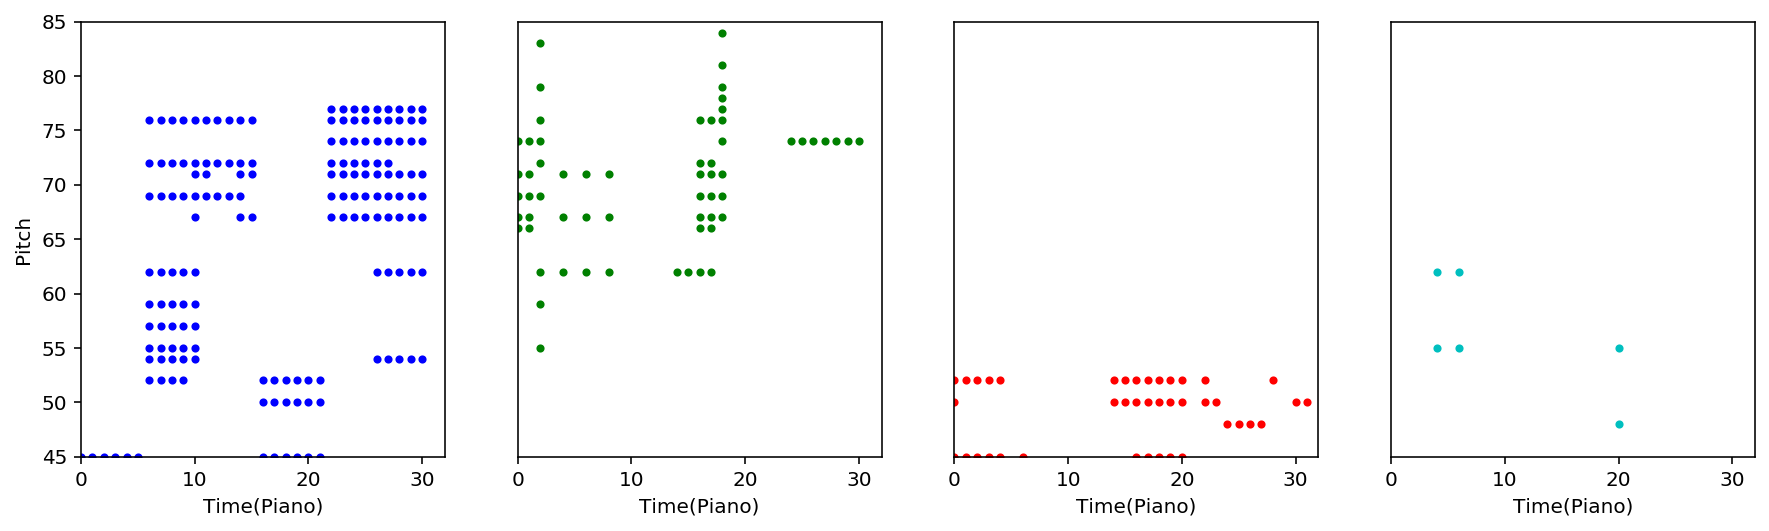

In [9]:
#double check the shape on training data, should be (x, 32, 128, 4), where x represents the amount of records
training_data = np.load(train_dir + '/reggae-train.npy')
print("Testing the training shape: ", training_data.shape)

#view sample of data that will be feed to model, four graphs == four tracks
display_utils.show_pianoroll(training_data)


# Prepare the Dataset and Build Model Architecture

> The code below is based on the Lab 2 code (with only minor modifications) provided by AWS in the AWS DeepComposer samples found here: https://github.com/aws-samples/aws-deepcomposer-samples/blob/master/Lab%202/GAN.ipynb. Please review for more detailed explanations and copyright info.

We now create a Tensorflow dataset object from our numpy array to feed into our model. The dataset object helps us feed batches of data into our model. A batch is a subset of the data that is passed through the deep learning network before the weights are updated. Batching data is necessary in most training scenarios as our training environment might not be able to load the entire dataset into memory at once.

In [10]:
#Number of input data samples in a batch
BATCH_SIZE = 5

#Shuffle buffer size for shuffling data
SHUFFLE_BUFFER_SIZE = 10

#Preloads PREFETCH_SIZE batches so that there is no idle time between batches
PREFETCH_SIZE = 2

In [11]:
def prepare_dataset(filename):
    
    """Load the samples used for training."""
    
    data = np.load(train_dir + '/reggae-train.npy')
    data = np.asarray(data, dtype=np.float32)  # {-1, 1}

    print('data shape = {}'.format(data.shape))

    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE).repeat()
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(PREFETCH_SIZE)

    return dataset 

dataset = prepare_dataset(train_dir + '/reggae-train.npy')

data shape = (5, 32, 128, 4)


## Model architecture
In this section, we will walk through the architecture of the proposed GAN.

The model consists of two networks, a generator and a critic. These two networks work in a tight loop as following:

* Generator:
    1. The generator takes in a batch of single-track piano rolls (melody) as the input and generates a batch of multi-track piano rolls as the output by adding accompaniments to each of the input music tracks. 
    2. The critic then takes these generated music tracks and predicts how far it deviates from the real data present in your training dataset.
    3. This feedback from the critic is used by the generator to update its weights.
* Critic: As the generator gets better at creating better music accompaniments using the feedback from the critic, the critic needs to be retrained as well.
    1. Train the critic with the music tracks just generated by the generator as fake inputs and an equivalent number of songs from the original dataset as the real input. 
* Alternate between training these two networks until the model converges and produces realistic music, beginning with the critic on the first iteration.

We use a special type of GAN called the **Wasserstein GAN with Gradient Penalty** (or **WGAN-GP**) to generate music. While the underlying architecture of a WGAN-GP is very similar to vanilla variants of GAN, WGAN-GPs help overcome some of the commonly seen defects in GANs such as the vanishing gradient problem and mode collapse (see appendix for more details).

Note our "critic" network is more generally called a "discriminator" network in the more general context of vanilla GANs.

### Generator

The generator is adapted from the U-Net architecture (a popular CNN that is used extensively in the computer vision domain), consisting of an “encoder” that maps the single track music data (represented as piano roll images) to a relatively lower dimensional “latent space“ and a ”decoder“ that maps the latent space back to multi-track music data.

Here are the inputs provided to the generator:

**Single-track piano roll input**: A single melody track of size (32, 128, 1) => (TimeStep, NumPitches, NumTracks) is provided as the input to the generator. 

**Latent noise vector**: A latent noise vector z of dimension (2, 8, 512) is also passed in as input and this is responsible for ensuring that there is a distinctive flavor to each output generated by the generator, even when the same input is provided.

Notice from the figure below that the encoding layers of the generator on the left side and decoder layer on on the right side are connected to create a U-shape, thereby giving the name U-Net to this architecture.

<img src="images/dgen.png" alt="Generator architecture" width="800">

In this implementation, we build the generator following a simple four-level Unet architecture by combining `_conv2d`s and `_deconv2d`, where `_conv2d` compose the contracting path and `_deconv2d` forms the expansive path. 

In [12]:
def _conv2d(layer_input, filters, f_size=4, bn=True):
    """Generator Basic Downsampling Block"""
    d = tf.keras.layers.Conv2D(filters, kernel_size=f_size, strides=2,
                               padding='same')(layer_input)
    d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
    if bn:
        d = tf.keras.layers.BatchNormalization(momentum=0.8)(d)
    return d


def _deconv2d(layer_input, pre_input, filters, f_size=4, dropout_rate=0):
    """Generator Basic Upsampling Block"""
    u = tf.keras.layers.UpSampling2D(size=2)(layer_input)
    u = tf.keras.layers.Conv2D(filters, kernel_size=f_size, strides=1,
                               padding='same')(u)
    u = tf.keras.layers.BatchNormalization(momentum=0.8)(u)
    u = tf.keras.layers.ReLU()(u)

    if dropout_rate:
        u = tf.keras.layers.Dropout(dropout_rate)(u)
        
    u = tf.keras.layers.Concatenate()([u, pre_input])
    return u

    
def build_generator(condition_input_shape=(32, 128, 1), filters=64,
                    instruments=4, latent_shape=(2, 8, 512)):
    """Buld Generator"""
    c_input = tf.keras.layers.Input(shape=condition_input_shape)
    z_input = tf.keras.layers.Input(shape=latent_shape)

    d1 = _conv2d(c_input, filters, bn=False)
    d2 = _conv2d(d1, filters * 2)
    d3 = _conv2d(d2, filters * 4)
    d4 = _conv2d(d3, filters * 8)

    d4 = tf.keras.layers.Concatenate(axis=-1)([d4, z_input])

    u4 = _deconv2d(d4, d3, filters * 4)
    u5 = _deconv2d(u4, d2, filters * 2)
    u6 = _deconv2d(u5, d1, filters)

    u7 = tf.keras.layers.UpSampling2D(size=2)(u6)
    output = tf.keras.layers.Conv2D(instruments, kernel_size=4, strides=1,
                               padding='same', activation='tanh')(u7)  # 32, 128, 4

    generator = tf.keras.models.Model([c_input, z_input], output, name='Generator')

    return generator

Let us now dive into each layer of the generator to see the inputs/outputs at each layer.

In [13]:
# Models
generator = build_generator()
generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 128, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 64, 64)   1088        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 16, 64, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 32, 128)   131200      leaky_re_lu[0][0]                
__________________________________________________________________________________________

### Critic (Discriminator)

The goal of the critic is to provide feedback to the generator about how realistic the generated piano rolls are, so that the generator can learn to produce more realistic data. The critic provides this feedback by outputting a scalar that  represents how “real” or “fake” a piano roll is.

Since the critic tries to classify data as “real” or “fake”, it is not very different from commonly used binary classifiers.  We use a simple architecture for the critic, composed of four convolutional layers and a dense layer at the end.

<img src="images/ddis.png" alt="Discriminator architecture" width="800">

In [14]:
def _build_critic_layer(layer_input, filters, f_size=4):
    """
    This layer decreases the spatial resolution by 2:

        input:  [batch_size, in_channels, H, W]
        output: [batch_size, out_channels, H/2, W/2]
    """
    d = tf.keras.layers.Conv2D(filters, kernel_size=f_size, strides=2,
                               padding='same')(layer_input)
    # Critic does not use batch-norm
    d = tf.keras.layers.LeakyReLU(alpha=0.2)(d) 
    return d


def build_critic(pianoroll_shape=(32, 128, 4), filters=64):
    """WGAN critic."""
    
    condition_input_shape = (32,128,1)
    groundtruth_pianoroll = tf.keras.layers.Input(shape=pianoroll_shape)
    condition_input = tf.keras.layers.Input(shape=condition_input_shape)
    combined_imgs = tf.keras.layers.Concatenate(axis=-1)([groundtruth_pianoroll, condition_input])


    
    d1 = _build_critic_layer(combined_imgs, filters)
    d2 = _build_critic_layer(d1, filters * 2)
    d3 = _build_critic_layer(d2, filters * 4)
    d4 = _build_critic_layer(d3, filters * 8)

    x = tf.keras.layers.Flatten()(d4)
    logit = tf.keras.layers.Dense(1)(x)

    critic = tf.keras.models.Model([groundtruth_pianoroll,condition_input], logit,
                                          name='Critic')
    

    return critic

In [15]:
# Create the Discriminator

critic = build_critic()
critic.summary() # View discriminator architecture.

Model: "Critic"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 128, 4)] 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 32, 128, 1)] 0                                            
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 32, 128, 5)   0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 16, 64, 64)   5184        concatenate_4[0][0]         

## Training

We train our models by searching for model parameters which optimize an objective function. For our WGAN-GP, we have special loss functions that we minimize as we alternate between training our generator and critic networks:

*Generator Loss:*
* We use the Wasserstein (Generator) loss function which is negative of the Critic Loss function. The generator is trained to bring the generated pianoroll as close to the real pianoroll as possible.
    * $\frac{1}{m} \sum_{i=1}^{m} -D_w(G(z^{i}|c^{i})|c^{i})$

*Critic Loss:*

* We begin with the Wasserstein (Critic) loss function designed to maximize the distance between the real piano roll distribution and generated (fake) piano roll distribution.
    * $\frac{1}{m} \sum_{i=1}^{m} [D_w(G(z^{i}|c^{i})|c^{i}) - D_w(x^{i}|c^{i})]$

* We add a gradient penalty loss function term designed to control how the gradient of the critic with respect to its input behaves.  This makes optimization of the generator easier. 
    * $\frac{1}{m} \sum_{i=1}^{m}(\lVert \nabla_{\hat{x}^i}D_w(\hat{x}^i|c^{i}) \rVert_2 -  1)^2 $

In [16]:
# Define the different loss functions

def generator_loss(critic_fake_output):
    """ Wasserstein GAN loss
    (Generator)  -D(G(z|c))
    """
    return -tf.reduce_mean(critic_fake_output)


def wasserstein_loss(critic_real_output, critic_fake_output):
    """ Wasserstein GAN loss
    (Critic)  D(G(z|c)) - D(x|c)
    """
    return tf.reduce_mean(critic_fake_output) - tf.reduce_mean(
        critic_real_output)


def compute_gradient_penalty(critic, x, fake_x):
    
    c = tf.expand_dims(x[..., 0], -1)
    batch_size = x.get_shape().as_list()[0]
    eps_x = tf.random.uniform(
        [batch_size] + [1] * (len(x.get_shape()) - 1))  # B, 1, 1, 1, 1
    inter = eps_x * x + (1.0 - eps_x) * fake_x

    with tf.GradientTape() as g:
        g.watch(inter)
        disc_inter_output = critic((inter,c), training=True)
    grads = g.gradient(disc_inter_output, inter)
    slopes = tf.sqrt(1e-8 + tf.reduce_sum(
        tf.square(grads),
        reduction_indices=tf.range(1, grads.get_shape().ndims)))
    gradient_penalty = tf.reduce_mean(tf.square(slopes - 1.0))
    
    return gradient_penalty


With our loss functions defined, we associate them with Tensorflow optimizers to define how our model will search for a good set of model parameters. We use the *Adam* algorithm, a commonly used general-purpose optimizer. We also set up checkpoints to save our progress as we train.

In [17]:
# Setup Adam optimizers for both G and D
generator_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5, beta_2=0.9)
critic_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5, beta_2=0.9)

# We define our checkpoint directory and where to save trained checkpoints
ckpt = tf.train.Checkpoint(generator=generator,
                           generator_optimizer=generator_optimizer,
                           critic=critic,
                           critic_optimizer=critic_optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, check_dir, max_to_keep=5)

Now we define the `generator_train_step` and `critic_train_step` functions, each of which performs a single forward pass on a batch and returns the corresponding loss.

In [18]:
@tf.function
def generator_train_step(x, condition_track_idx=0):

    ############################################
    #(1) Update G network: maximize D(G(z|c))
    ############################################

    # Extract condition track to make real batches pianoroll
    c = tf.expand_dims(x[..., condition_track_idx], -1)

    # Generate batch of latent vectors
    z = tf.random.truncated_normal([BATCH_SIZE, 2, 8, 512])

    with tf.GradientTape() as tape:
        fake_x = generator((c, z), training=True)
        fake_output = critic((fake_x,c), training=False)

        # Calculate Generator's loss based on this generated output
        gen_loss = generator_loss(fake_output)

    # Calculate gradients for Generator
    gradients_of_generator = tape.gradient(gen_loss,
                                           generator.trainable_variables)
    # Update Generator
    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables))

    return gen_loss


In [19]:
@tf.function
def critic_train_step(x, condition_track_idx=0):

    ############################################################################
    #(2) Update D network: maximize (D(x|c)) + (1 - D(G(z|c))|c) + GradientPenality() 
    ############################################################################

    # Extract condition track to make real batches pianoroll
    c = tf.expand_dims(x[..., condition_track_idx], -1)

    # Generate batch of latent vectors
    z = tf.random.truncated_normal([BATCH_SIZE, 2, 8, 512])

    # Generated fake pianoroll
    fake_x = generator((c, z), training=False)


    # Update critic parameters
    with tf.GradientTape() as tape:
        real_output = critic((x,c), training=True)
        fake_output = critic((fake_x,c), training=True)
        critic_loss =  wasserstein_loss(real_output, fake_output)

    # Caculate the gradients from the real and fake batches
    grads_of_critic = tape.gradient(critic_loss,
                                               critic.trainable_variables)

    with tf.GradientTape() as tape:
        gp_loss = compute_gradient_penalty(critic, x, fake_x)
        gp_loss *= 10.0

    # Calculate the gradients penalty from the real and fake batches
    grads_gp = tape.gradient(gp_loss, critic.trainable_variables)
    gradients_of_critic = [g + ggp for g, ggp in
                                  zip(grads_of_critic, grads_gp)
                                  if ggp is not None]

    # Update Critic
    critic_optimizer.apply_gradients(
        zip(gradients_of_critic, critic.trainable_variables))

    return critic_loss + gp_loss


Before we begin training, let's define some training configuration parameters and prepare to monitor important quantities. Here we log the losses and metrics which we can use to determine when to stop training. Consider coming back here to tweak these parameters and explore how your model responds. 

In [20]:
# We use load_melody_samples() to load 5 input data samples from our dataset into sample_x 
# and 5 random noise latent vectors into sample_z
sample_x, sample_z = inference_utils.load_melody_samples(n_sample=5)

Loaded 5 melody samples


In [21]:
# Number of iterations to train for
iterations = 200

# Update critic n times per generator update 
n_dis_updates_per_gen_update = 5

# Determine input track in sample_x that we condition on
condition_track_idx = 0 
sample_c = tf.expand_dims(sample_x[..., condition_track_idx], -1)

Let us now train our model!

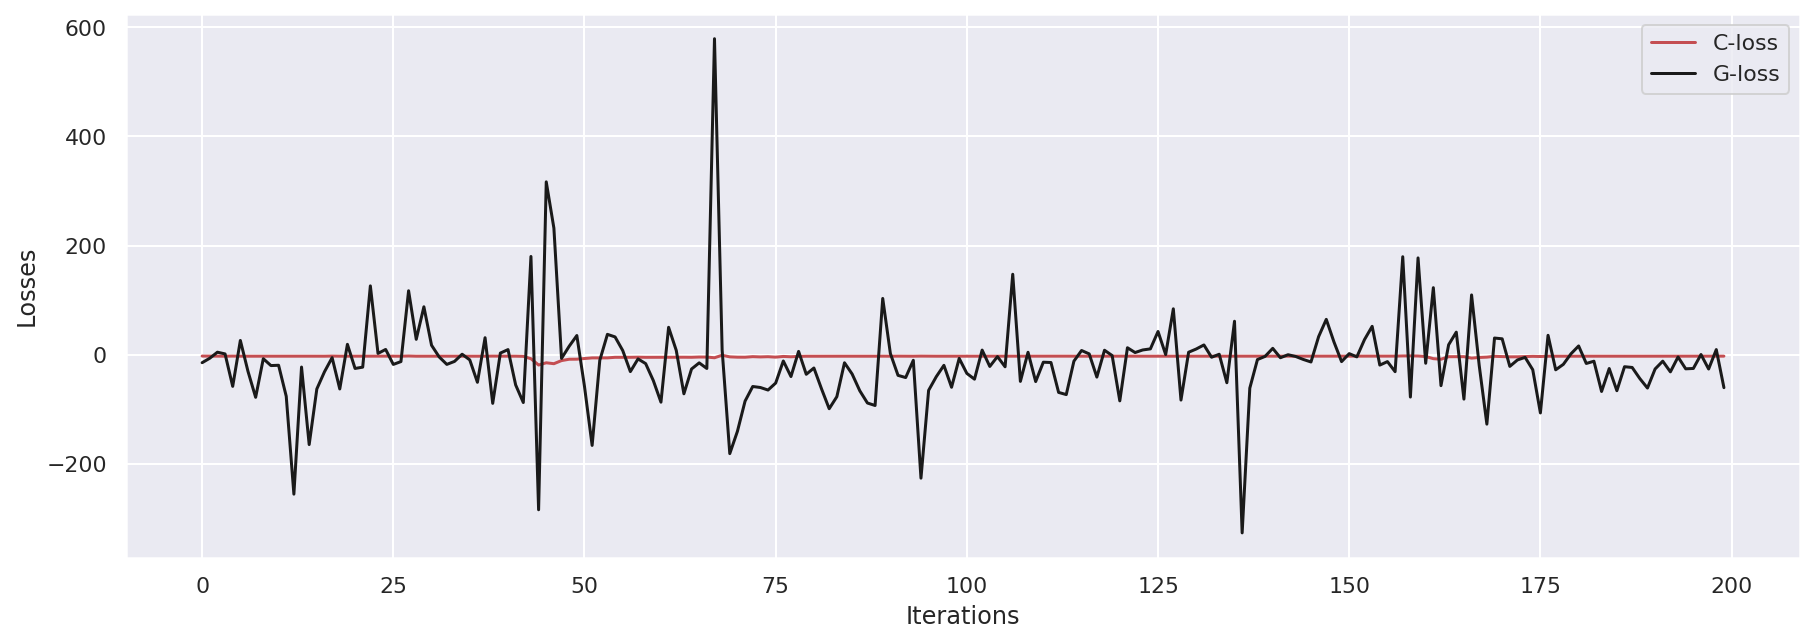

Iteration 199, c_loss=-2.92, g_loss=-60.78


In [33]:
# Clear out any old metrics we've collected
metrics_utils.metrics_manager.initialize()

# Keep a running list of various quantities:
c_losses = []
g_losses = []

# Data iterator to iterate over our dataset
it = iter(dataset)

for iteration in range(iterations):

    # Train critic
    for _ in range(n_dis_updates_per_gen_update):
        c_loss = critic_train_step(next(it))

    # Train generator
    g_loss = generator_train_step(next(it))

    # Save Losses for plotting later
    c_losses.append(c_loss)
    g_losses.append(g_loss)

    display.clear_output(wait=True)
    fig = plt.figure(figsize=(15, 5))
    line1, = plt.plot(range(iteration+1), c_losses, 'r')
    line2, = plt.plot(range(iteration+1), g_losses, 'k')
    plt.xlabel('Iterations')
    plt.ylabel('Losses')
    plt.legend((line1, line2), ('C-loss', 'G-loss'))
    display.display(fig)
    plt.close(fig)
    
    # Output training stats
    print('Iteration {}, c_loss={:.2f}, g_loss={:.2f}'.format(iteration, c_loss, g_loss))
    
    # Save checkpoints, music metrics, generated output
    if iteration < 100 or iteration % 50 == 0 :
        # Check how the generator is doing by saving G's samples on fixed_noise
        fake_sample_x = generator((sample_c, sample_z), training=False)
        metrics_utils.metrics_manager.append_metrics_for_iteration(fake_sample_x.numpy(), iteration)

        if iteration % 50 == 0:
            # Save the checkpoint to disk.
            ckpt_manager.save(checkpoint_number=iteration) 
        
            fake_sample_x = fake_sample_x.numpy()
    
            # plot the pianoroll
            display_utils.plot_pianoroll(iteration, sample_x[:4], fake_sample_x[:4], save_dir=train_dir)

            # generate the midi
            destination_path = path_utils.generated_midi_path_for_iteration(iteration, saveto_dir=sample_dir)
            
            #use the programs to provide the program numbers for the instruments I care about
            # 17 = Drawbar Organ, 28 = Electric Guitar, 27 = Electric Guitar, 11 = Music Box
            # TODO: CHANGE THIS BASED ON YOUR SPECIFIC DATASET
            midi_utils.save_pianoroll_as_midi(fake_sample_x[:4], programs=[17, 28, 27, 11], destination_path=destination_path)


### We have started training!

When using the Wasserstein loss function, we should train the critic to converge to ensure that the gradients for the generator update are accurate. This is in contrast to a standard GAN, where it is important not to let the critic get too strong, to avoid vanishing gradients.

Therefore, using the Wasserstein loss removes one of the key difficulties of training GANs—how to balance the training of the discriminator and generator. With WGANs, we can simply train the critic several times between generator updates, to ensure it is close to convergence. A typical ratio used is five critic updates to one generator update.

### "Babysitting" the learning process

Given that training these models can be an investment in time and resources, we must to continuously monitor training in order to catch and address anomalies if/when they occur. Here are some things to look out for:

**What should the losses look like?**

The adversarial learning process is highly dynamic and high-frequency oscillations are quite common. However if either loss (critic or generator) skyrockets to huge values, plunges to 0, or get stuck on a single value, there is likely an issue somewhere.

**Is my model learning?**
- Monitor the critic loss and other music quality metrics (if applicable). Are they following the expected trajectories?
- Monitor the generated samples (piano rolls). Are they improving over time? Do you see evidence of mode collapse? Have you tried listening to your samples?

**How do I know when to stop?**
- If the samples meet your expectations
- Critic loss no longer improving
- The expected value of the musical quality metrics converge to the corresponding expected value of the same metric on the training data

### How to measure sample quality during training 

Typically, when training any sort of neural networks, it is standard practice to monitor the value of the loss function throughout the duration of the training. The critic loss in WGANs has been found to correlate well with sample quality.

While standard mechanisms exist for evaluating the accuracy of more traditional models like classifiers or regressors, evaluating generative models is an active area of research. Within the domain of music generation, this hard problem is even less well-understood.

To address this, we take high-level measurements of our data and show how well our model produces music that aligns with those measurements. If our model produces music which is close to the mean value of these measurements for our training dataset, our music should match on general “shape”.

We’ll look at three such measurements:
- **Empty bar rate:** The ratio of empty bars to total number of bars.
- **Pitch histogram distance:** A metric that captures the distribution and position of pitches.
- **In Scale Ratio:** Ratio of the number of notes that are in C major key, which is a common key found in music, to the total number of notes. 


## Evaluate results

Now that we have finished training, let's find out how we did. We will analyze our model in several ways:
1. Examine how the generator and critic losses changed while training
2. Understand how certain musical metrics changed while training
3. Visualize generated piano roll output for a fixed input at every iteration and create a video


Let us first restore our last saved checkpoint. If you did not complete training but still want to continue with a pre-trained version, set `TRAIN = False`.

In [23]:
ckpt = tf.train.Checkpoint(generator=generator)
ckpt_manager = tf.train.CheckpointManager(ckpt, check_dir, max_to_keep=5)

ckpt.restore(ckpt_manager.latest_checkpoint).expect_partial()
print('Latest checkpoint {} restored.'.format(ckpt_manager.latest_checkpoint))

Latest checkpoint ./Experiments/2Reggae/preload/ckpt-150 restored.


### Plot losses

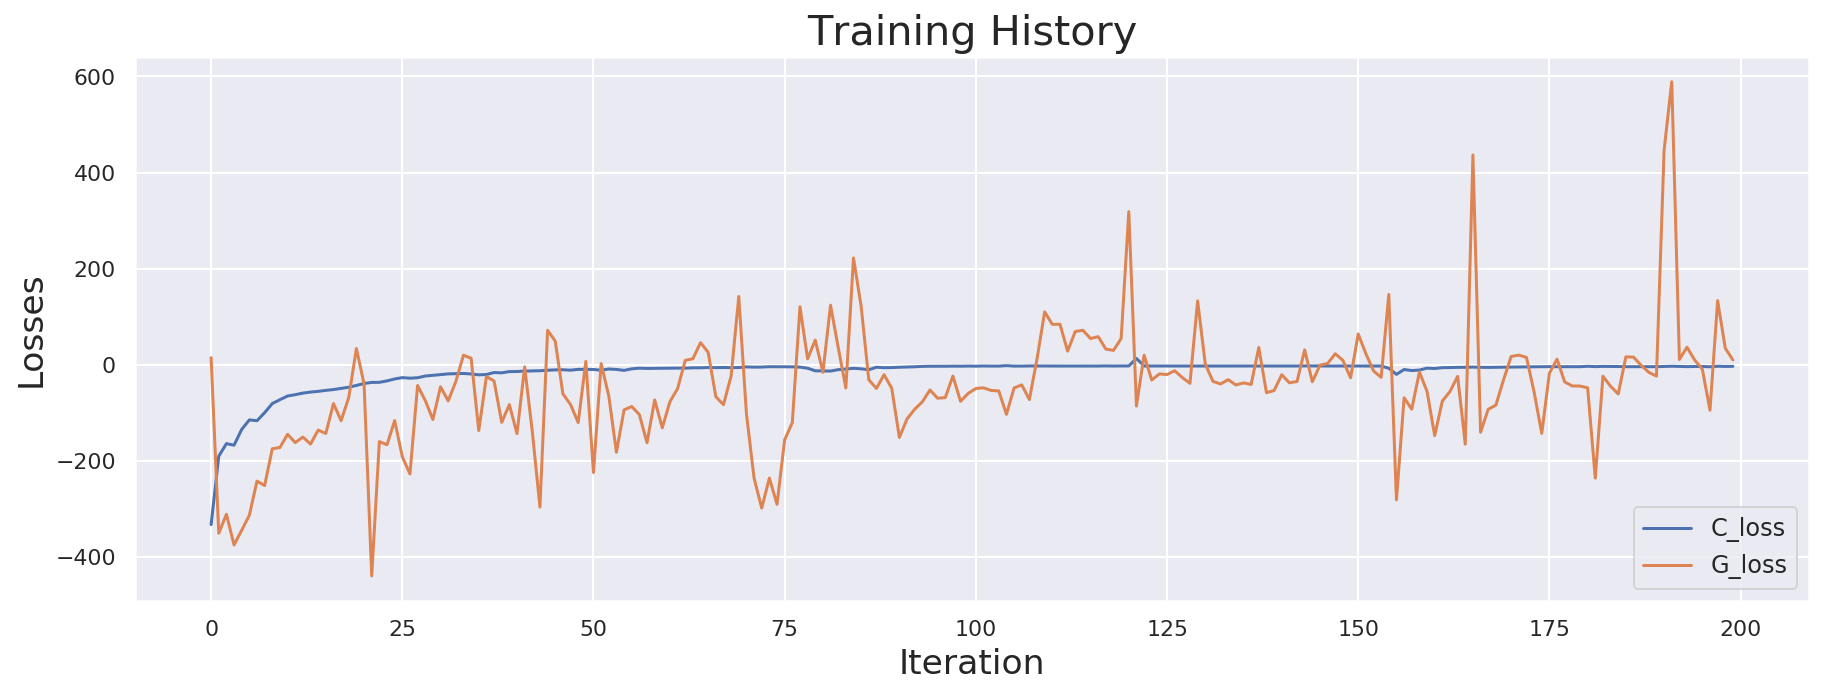

In [24]:
display_utils.plot_loss_logs(g_losses, c_losses, figsize=(15, 5), smoothing=0.01)

Observe how the critic loss (C_loss in the graph) decays to zero as we train. In WGAN-GPs, the critic loss decreases (almost) monotonically as you train.

### Plot metrics

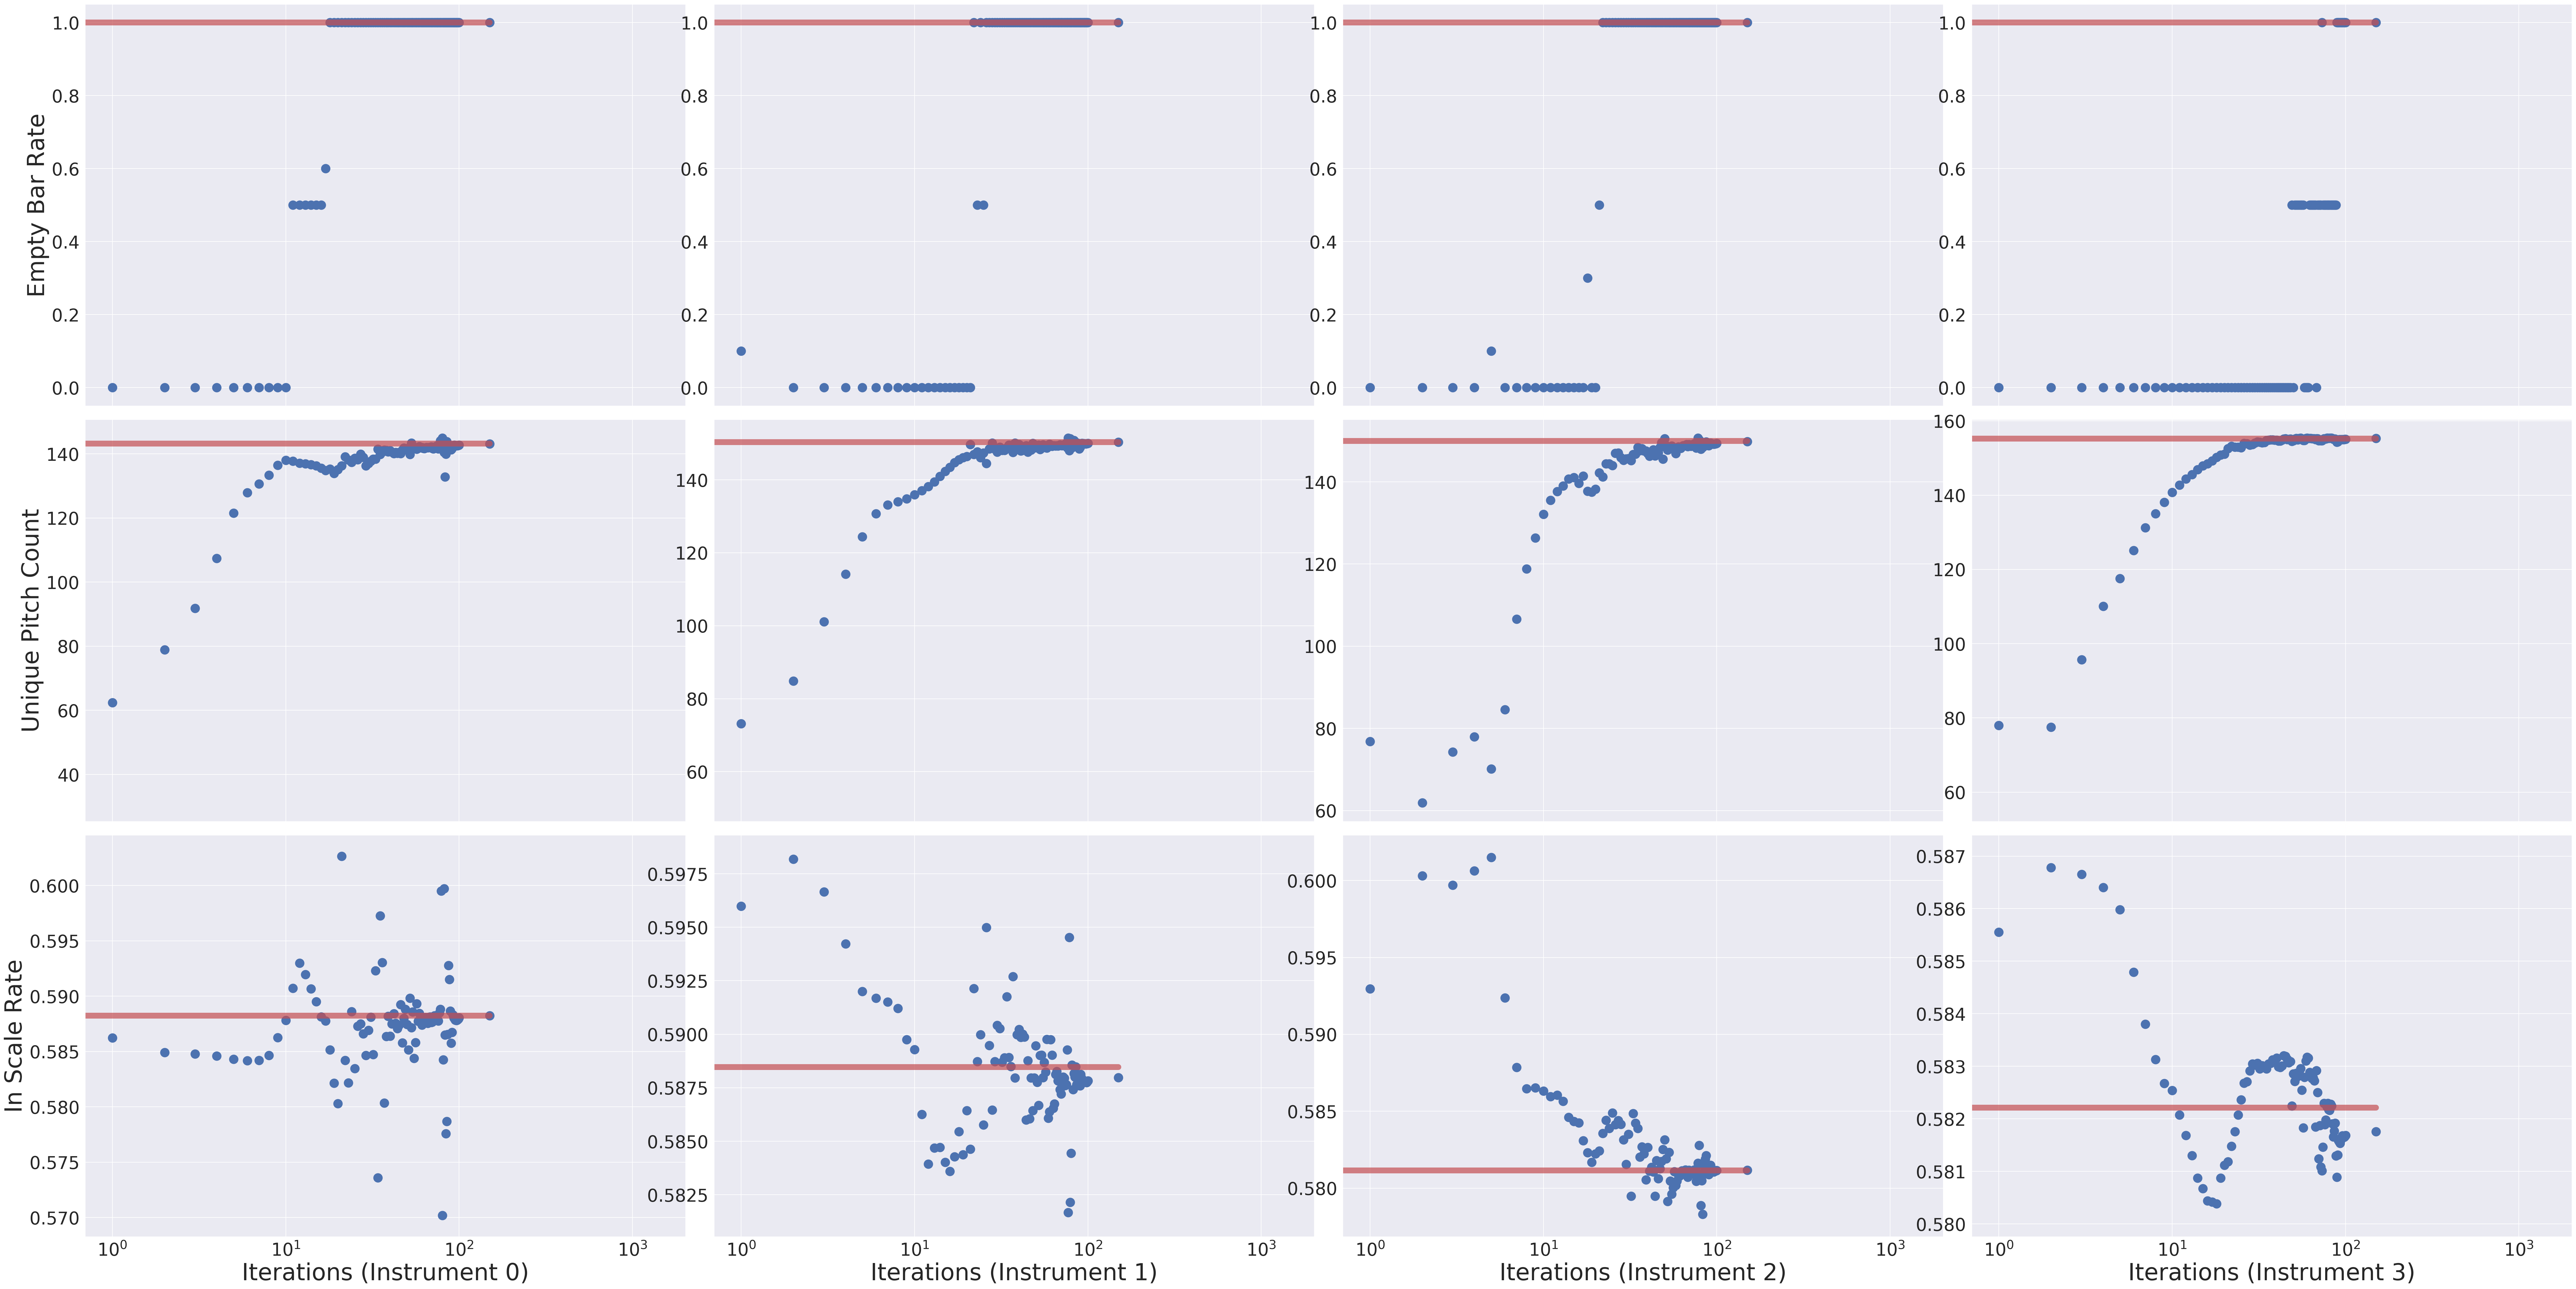

In [25]:
metrics_utils.metrics_manager.set_reference_metrics(training_data)
metrics_utils.metrics_manager.plot_metrics()

Each row here corresponds to a different music quality metric and each column denotes an instrument track. 

Observe how the expected value of the different metrics (blue scatter) approach the corresponding training set expected values (red) as the number of iterations increase. You might expect to see diminishing returns as the model converges.


### Generated samples during training

The function below helps you probe intermediate samples generated in the training process. Remember that the conditioned input here is sampled from our training data. Let's start by listening to and observing a sample at iteration 0 and then iteration 100. Notice the difference!



In [26]:
# Enter an iteration number (can be divided by 50) and listen to the midi at that iteration
# Had 200 iterations

iteration = 150
midi_file = os.path.join(sample_dir, 'iteration-{}.mid'.format(iteration))
display_utils.playmidi(midi_file)    

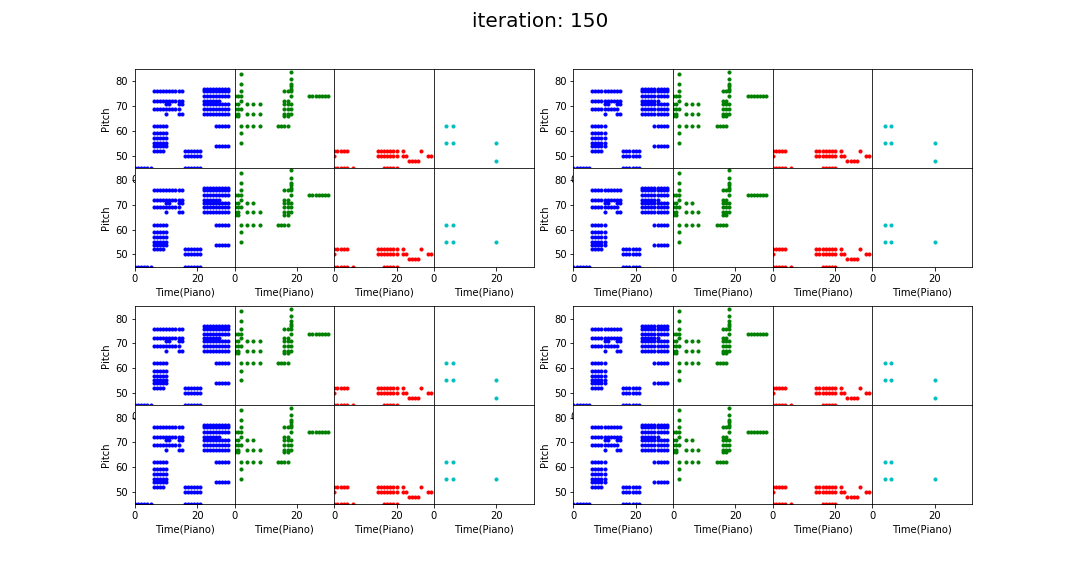

In [27]:
# Enter an iteration number (can be divided by 50) and look at the generated pianorolls at that iteration
iteration = 150
pianoroll_png = os.path.join(train_dir, 'sample_iteration_%05d.png' % iteration)
display.Image(filename=pianoroll_png)

Let's see how the generated piano rolls change with the number of iterations.

In [28]:
from IPython.display import Video


display_utils.make_training_video(train_dir)
video_path = "movie.mp4"
Video(video_path)

t:   7%|▋         | 4/60 [00:00<00:01, 34.02it/s, now=None]

Moviepy - Building video movie.mp4.
Moviepy - Writing video movie.mp4



Moviepy - Done !
Moviepy - video ready movie.mp4


## Inference 

### Generating accompaniment for custom input

Congratulations! You have trained your very own WGAN-GP to generate music. Let us see how our generator performs on a custom input.

The function below generates a new song based on "One Love (Bob Marley)".

In [29]:
conditioned_track = midi_utils.get_conditioned_track(midi='./one-love.midi')
generated_pianoroll = inference_utils.generate_pianoroll(generator, conditioned_track)

destination_path = path_utils.new_temp_midi_path(saveto_dir=eval_dir)

# 17 = Drawbar Organ, 28 = Electric Guitar, 27 = Electric Guitar, 11 = Music Box
# TODO: CHANGE THIS BASED ON YOUR SPECIFIC DATASET
midi_utils.save_pianoroll_as_midi(generated_pianoroll.numpy(), destination_path=destination_path, programs=[17, 28, 27, 11],)

latest_midi = destination_path

Midi saved to  ./Experiments/2Reggae/eval/temp-0.mid


In [30]:
display_utils.playmidi(latest_midi)

We can also take a look at the generated piano rolls for a certain sample, to see how diverse they are!

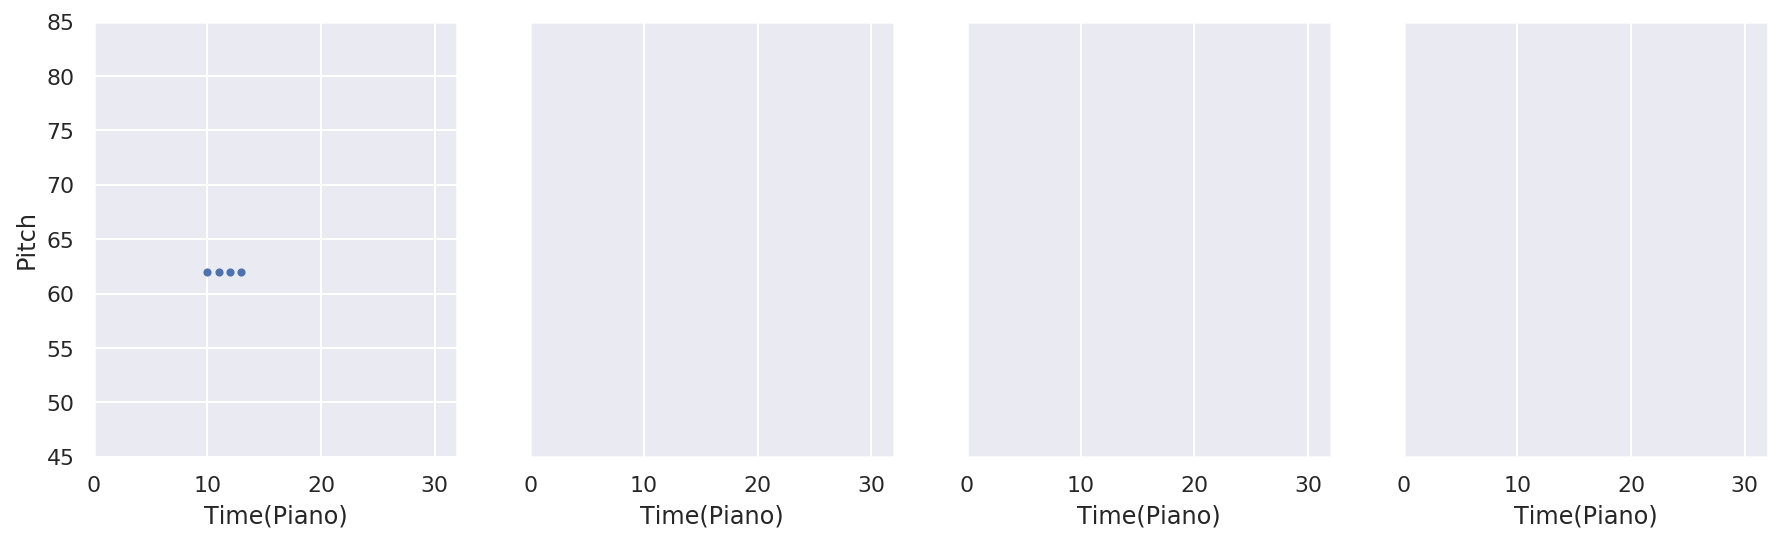

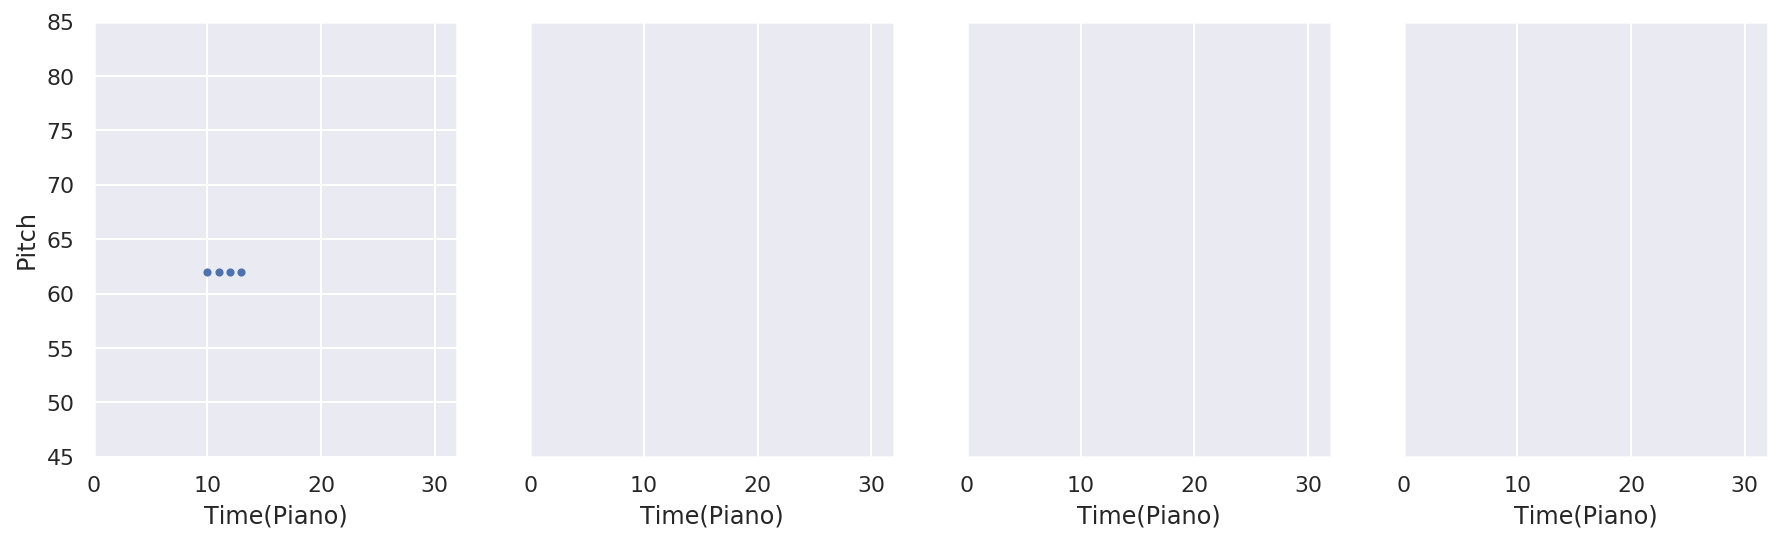

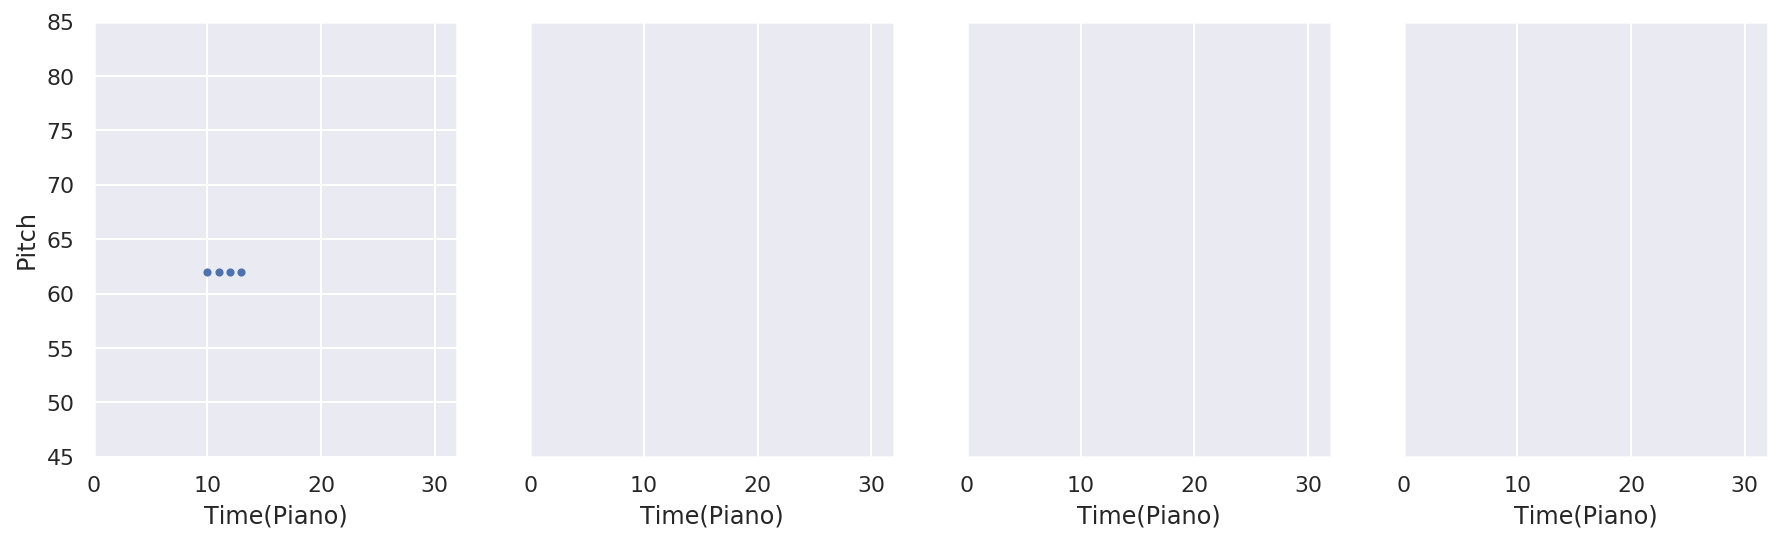

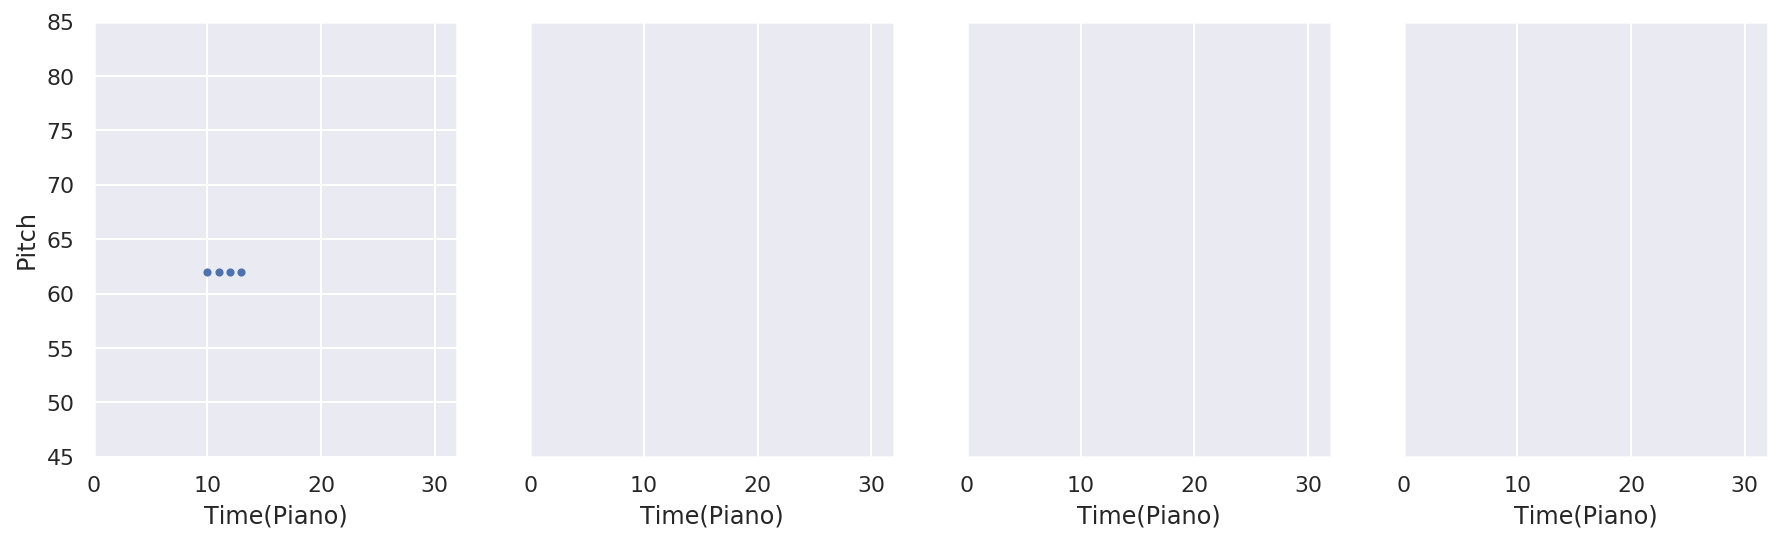

In [31]:
inference_utils.show_generated_pianorolls(generator, eval_dir, input_midi_file='./one-love.midi')